# Interannotator Agreement

In [78]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import simpledorff
import math


In [79]:
# Load Combined_Data.xlsx
combined_data = pd.read_excel('Combined_Data.xlsx')

# GSM8k data - limit to task = "gsm8k"
gsm8k_data = combined_data[combined_data['task'] == 'gsm8k']

# Creative writing data - limit to task = "cw"
cw_data = combined_data[combined_data['task'] == 'cw']

# Load direct_prompting_comparison.xlsx
direct_prompting_comparison = pd.read_excel('direct_prompting_comparison.xlsx')


In [80]:
print(cw_data.columns)


Index(['model_task_method', 'conversation_number',
       'coherence_1_incoherent_10_very_coherent',
       'task_constraints_followed_0_not_followed_1_followed',
       'ease_of_review_1_easy_10_hard', 'correct',
       'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10',
       'Aggregated_Prediction', 'Prediction_Based_On_First_10_LP',
       'response_Based_On_First_10_LP', 'Prediction_Based_On_Last_10_LP',
       'response_Based_On_Last_10_LP', 'response_LP',
       'Aggregated_Prediction_LP', 'Prediction_Based_On_First_50_LP',
       'response_Based_On_First_50_LP', 'Prediction_Based_On_Last_50_LP',
       'response_Based_On_Last_50_LP', 'Aggregated_Prediction_50_LP',
       'Prediction_Based_On_random_50_LP_1',
       'response_Based_On_random_50_LP_1',
       'Prediction_Based_On_random_50_LP_2',
       'response_Based_On_random_50_LP_2',
       'Aggregated_Prediction_random_50_LP', 'conversation_length',
       'input_length', 'output_length', 'conversation_cost',
  

## Initial Checks on First-Pass Fine-Tuning Results

In [81]:
# Summary statistics for variables: coherence_1_incoherent_10_very_coherent, Prediction_Based_On_First_10, Prediction_Based_On_Last_10, Aggregated_Prediction
print(cw_data[['coherence_1_incoherent_10_very_coherent', 'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10', 'Aggregated_Prediction']].describe())


       coherence_1_incoherent_10_very_coherent  Prediction_Based_On_First_10  \
count                              1600.000000                   1440.000000   
mean                                  4.974375                      5.403472   
std                                   2.612563                      2.175833   
min                                   1.000000                      1.000000   
25%                                   3.000000                      3.000000   
50%                                   5.000000                      7.000000   
75%                                   7.000000                      7.000000   
max                                  10.000000                      8.000000   

       Prediction_Based_On_Last_10  Aggregated_Prediction  
count                  1440.000000            1600.000000  
mean                      4.066667               4.722500  
std                       2.569885               2.265422  
min                       1.000000     

DescribeResult(nobs=1600, minmax=(-7.0, 8.0), mean=0.251875, variance=5.838020247029392, skewness=-0.006411691981771768, kurtosis=0.18078123260822876)


(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  23.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

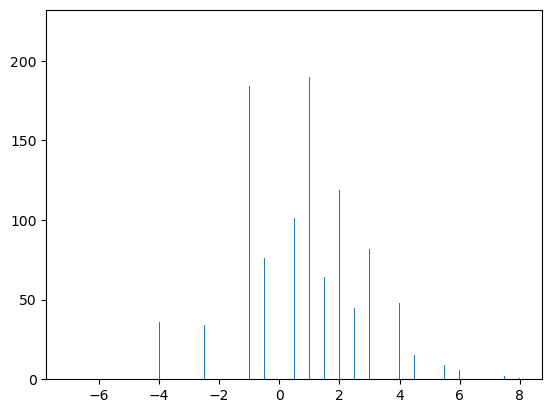

In [82]:
# Differences between coherence_1_incoherent_10_very_coherent and Aggregated_Prediction
print(stats.describe(cw_data['coherence_1_incoherent_10_very_coherent'] - cw_data['Aggregated_Prediction']))

# Histogram
plt.hist(cw_data['coherence_1_incoherent_10_very_coherent'] - cw_data['Aggregated_Prediction'], bins = 1000)


In [83]:
print(cw_data.columns)


Index(['model_task_method', 'conversation_number',
       'coherence_1_incoherent_10_very_coherent',
       'task_constraints_followed_0_not_followed_1_followed',
       'ease_of_review_1_easy_10_hard', 'correct',
       'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10',
       'Aggregated_Prediction', 'Prediction_Based_On_First_10_LP',
       'response_Based_On_First_10_LP', 'Prediction_Based_On_Last_10_LP',
       'response_Based_On_Last_10_LP', 'response_LP',
       'Aggregated_Prediction_LP', 'Prediction_Based_On_First_50_LP',
       'response_Based_On_First_50_LP', 'Prediction_Based_On_Last_50_LP',
       'response_Based_On_Last_50_LP', 'Aggregated_Prediction_50_LP',
       'Prediction_Based_On_random_50_LP_1',
       'response_Based_On_random_50_LP_1',
       'Prediction_Based_On_random_50_LP_2',
       'response_Based_On_random_50_LP_2',
       'Aggregated_Prediction_random_50_LP', 'conversation_length',
       'input_length', 'output_length', 'conversation_cost',
  

In [84]:
# Krippendorff's alpha
# I am using the simpledorff package
# experiment_col should be the conversation (row of the dataframe) - create model_task_method_conversation_id
# annotator_col should be 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'
# class col should be the score from coherence_1_incoherent_10_very_coherent, Prediction_Based_On_First_10, Prediction_Based_On_Last_10

# Manipulate and reshape dataframe
cw_data['model_task_method_conversation_id'] = cw_data['model'] + '_' + cw_data['task'] + '_' + cw_data['method'] + '_' + cw_data['conversation_number'].astype(str)
cw_data['Human'] = cw_data['coherence_1_incoherent_10_very_coherent']
cw_data['GPT-3.5 - First 10'] = cw_data['Prediction_Based_On_First_10']
cw_data['GPT-3.5 - Last 10'] = cw_data['Prediction_Based_On_Last_10']
ka_data = cw_data[['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_melted = ka_data.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_melted = ka_data_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})

# Calculate Krippendorff's alpha
print('overall KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))

# Version excluding first 10
ka_data_no_first_10 = cw_data[cw_data['conversation_number'] > 10][['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_no_first_10_melted = ka_data_no_first_10.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_no_first_10_melted = ka_data_no_first_10_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('no first 10 KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_no_first_10_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))

# Version excluding last 10
ka_data_no_last_10 = cw_data[cw_data['conversation_number'] <= 90][['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_no_last_10_melted = ka_data_no_last_10.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_no_last_10_melted = ka_data_no_last_10_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('no last 10 KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_no_last_10_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))

# Version excluding first and last 10
ka_data_no_first_last_10 = cw_data[(cw_data['conversation_number'] > 10) & (cw_data['conversation_number'] <= 90)][['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_no_first_last_10_melted = ka_data_no_first_last_10.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_no_first_last_10_melted = ka_data_no_first_last_10_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('no first and last 10 KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_no_first_last_10_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


overall KA
0.10686929311619198
no first 10 KA


C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\1729583903.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['model_task_method_conversation_id'] = cw_data['model'] + '_' + cw_data['task'] + '_' + cw_data['method'] + '_' + cw_data['conversation_number'].astype(str)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\1729583903.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['Human'] = cw_data['coherence_1_incoherent_10_very_coherent']
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\1

0.10782815485733388
no last 10 KA
0.11024510661584563
no first and last 10 KA
0.11158211702182685


In [85]:
# Try aggregated predictions
ka_data_agg = cw_data[['model_task_method_conversation_id', 'Human', 'Aggregated_Prediction']]
ka_data_agg_melted = ka_data_agg.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'Aggregated_Prediction'])
ka_data_agg_melted = ka_data_agg_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('aggregated predictions KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_agg_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


aggregated predictions KA
0.04803932294886726


In [86]:
# Try to demand less of the data - in ka_data_melted, bin 1-10 into 1-5
# Divide by 2 and take the ceiling
ka_data_melted['coherence_1_to_5'] = ka_data_melted.dropna()['coherence_score'].apply(lambda x: math.ceil(x/2))

# Calculate Krippendorff's alpha
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                       experiment_col='model_task_method_conversation_id',
                                                       annotator_col='grader',
                                                       class_col='coherence_1_to_5'))


0.18525258256529475


In [87]:
# Try coherence on a scale of 1 to 3
ka_data_melted['coherence_1_to_3'] = ka_data_melted.dropna()['coherence_score'].apply(lambda x: math.ceil(x/3.33))

# Calculate Krippendorff's alpha
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                       experiment_col='model_task_method_conversation_id',
                                                       annotator_col='grader',
                                                       class_col='coherence_1_to_3'))


0.2735720914000721


In [88]:
# Try coherence vs incoherence binary
ka_data_melted['coherence_binary'] = ka_data_melted.dropna()['coherence_score'].apply(lambda x: 1 if x > 5 else 0)

# Calculate Krippendorff's alpha
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                       experiment_col='model_task_method_conversation_id',
                                                       annotator_col='grader',
                                                       class_col='coherence_binary'))


0.4195238892015637


## Fine-tuning with longer prompts

In [89]:
# Manipulate and reshape dataframe
cw_data['GPT-3.5 - First 10 - LP'] = cw_data['Prediction_Based_On_First_10_LP']
cw_data['GPT-3.5 - Last 10 - LP'] = cw_data['Prediction_Based_On_Last_10_LP']
ka_data_lp = cw_data[['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10 - LP', 'GPT-3.5 - Last 10 - LP']]
ka_data_melted_lp = ka_data_lp.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10 - LP', 'GPT-3.5 - Last 10 - LP'])
ka_data_melted_lp = ka_data_melted_lp.rename(columns={'variable': 'grader', 'value': 'coherence_score'})

# Calculate Krippendorff's alpha
print('overall KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted_lp,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


overall KA
0.14655382629441482


C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\800768595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['GPT-3.5 - First 10 - LP'] = cw_data['Prediction_Based_On_First_10_LP']
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\800768595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['GPT-3.5 - Last 10 - LP'] = cw_data['Prediction_Based_On_Last_10_LP']


In [90]:
# Try aggregated predictions
ka_data_agg_lp = cw_data[['model_task_method_conversation_id', 'Human', 'Aggregated_Prediction_LP']]
ka_data_agg_melted_lp = ka_data_agg_lp.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'Aggregated_Prediction_LP'])
ka_data_agg_melted_lp = ka_data_agg_melted_lp.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('aggregated predictions KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_agg_melted_lp,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


aggregated predictions KA
0.06459910514503153


### Using half the data

In [91]:
# Manipulate and reshape dataframe
cw_data['GPT-3.5 - First 50 - LP'] = cw_data['Prediction_Based_On_First_50_LP']
cw_data['GPT-3.5 - Last 50 - LP'] = cw_data['Prediction_Based_On_Last_50_LP']
ka_data_lp_50 = cw_data[['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 50 - LP', 'GPT-3.5 - Last 50 - LP']]
ka_data_melted_lp_50 = ka_data_lp_50.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 50 - LP', 'GPT-3.5 - Last 50 - LP'])
ka_data_melted_lp_50 = ka_data_melted_lp_50.rename(columns={'variable': 'grader', 'value': 'coherence_score'})

# Calculate Krippendorff's alpha
print('overall KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted_lp_50,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


overall KA
0.14723679091121322


C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\672138764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['GPT-3.5 - First 50 - LP'] = cw_data['Prediction_Based_On_First_50_LP']
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\672138764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['GPT-3.5 - Last 50 - LP'] = cw_data['Prediction_Based_On_Last_50_LP']


In [92]:
print(cw_data.columns)


Index(['model_task_method', 'conversation_number',
       'coherence_1_incoherent_10_very_coherent',
       'task_constraints_followed_0_not_followed_1_followed',
       'ease_of_review_1_easy_10_hard', 'correct',
       'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10',
       'Aggregated_Prediction', 'Prediction_Based_On_First_10_LP',
       'response_Based_On_First_10_LP', 'Prediction_Based_On_Last_10_LP',
       'response_Based_On_Last_10_LP', 'response_LP',
       'Aggregated_Prediction_LP', 'Prediction_Based_On_First_50_LP',
       'response_Based_On_First_50_LP', 'Prediction_Based_On_Last_50_LP',
       'response_Based_On_Last_50_LP', 'Aggregated_Prediction_50_LP',
       'Prediction_Based_On_random_50_LP_1',
       'response_Based_On_random_50_LP_1',
       'Prediction_Based_On_random_50_LP_2',
       'response_Based_On_random_50_LP_2',
       'Aggregated_Prediction_random_50_LP', 'conversation_length',
       'input_length', 'output_length', 'conversation_cost',
  

In [93]:
# Try aggregated predictions
ka_data_agg_lp_50 = cw_data[['model_task_method_conversation_id', 'Human', 'Aggregated_Prediction_50_LP']]
ka_data_agg_melted_lp_50 = ka_data_agg_lp_50.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'Aggregated_Prediction_50_LP'])
ka_data_agg_melted_lp_50 = ka_data_agg_melted_lp_50.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('aggregated predictions KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_agg_melted_lp_50,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


aggregated predictions KA
0.14723679091121322


### Using random 50% split

In [94]:
# Manipulate and reshape dataframe
cw_data['GPT-3.5 - Random 50 - LP - 1'] = cw_data['Prediction_Based_On_random_50_LP_1']
cw_data['GPT-3.5 - Random 50 - LP - 2'] = cw_data['Prediction_Based_On_random_50_LP_2']
ka_data_random_lp_50 = cw_data[['model_task_method_conversation_id', 'Human', 'GPT-3.5 - Random 50 - LP - 1', 'GPT-3.5 - Random 50 - LP - 2']]
ka_data_melted_random_lp_50 = ka_data_random_lp_50.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - Random 50 - LP - 1', 'GPT-3.5 - Random 50 - LP - 2'])
ka_data_melted_random_lp_50 = ka_data_melted_random_lp_50.rename(columns={'variable': 'grader', 'value': 'coherence_score'})

# Calculate Krippendorff's alpha
print('overall KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted_random_lp_50,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


overall KA
0.16701274040997383


C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\2104129242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['GPT-3.5 - Random 50 - LP - 1'] = cw_data['Prediction_Based_On_random_50_LP_1']
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23036\2104129242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['GPT-3.5 - Random 50 - LP - 2'] = cw_data['Prediction_Based_On_random_50_LP_2']


In [96]:
# Try aggregated predictions
ka_data_agg_random_lp_50 = cw_data[['model_task_method_conversation_id', 'Human', 'Aggregated_Prediction_random_50_LP']]
ka_data_agg_melted_random_lp_50 = ka_data_agg_random_lp_50.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'Aggregated_Prediction_random_50_LP'])
ka_data_agg_melted_random_lp_50 = ka_data_agg_melted_random_lp_50.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('aggregated predictions KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_agg_melted_random_lp_50,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


aggregated predictions KA
0.16701274040997383


### Investigate Preferences